## Loading libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from numpy.ma.core import ceil
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [2]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

### Defining loading functions

In [3]:
def add_new_month(df, path):
    '''
    adding a new month for one area (street csv)
    '''
    newmonth = pd.read_csv(path)
    newmonth['year'] = (newmonth.Month.map(lambda x: x.split('-')[0])).astype(int)
    newmonth['mon'] = (newmonth.Month.map(lambda x: x.split('-')[-1])).astype(int)
    newmonthcrimes = newmonth.groupby(['Falls within', 'Month','Crime type']).year.count().reset_index()
    newmonthcrimes['month'] = pd.to_datetime(newmonthcrimes.Month)
    df_type = newmonthcrimes.rename(columns={'Falls within': 'area',
                                 'year': 'crime'}).drop('Month', axis=1).set_index(['month', 'area', 'Crime type'])
    newmonthcrime = newmonth.groupby(['Falls within', 'Month']).year.count().reset_index()
    newmonthcrime['month'] = pd.to_datetime(newmonthcrime.Month)
    newmonthcrime = newmonthcrime.rename(columns={
        'Falls within': 'area',
        'year': 'crime'
    }).drop('Month', axis=1).set_index(['month', 'area'])

    columns = ['crime'] + list(set(newmonth['Crime type']))
    crime_list = set(newmonth['Crime type'])
    newmonthcrime = newmonthcrime.reindex(columns=columns)

    for i in newmonthcrime.index:
        for crime in crime_list:
            try:
                newmonthcrime[crime][i] = newmonthcrimes['crime'][i + (crime, )]
            except:
                newmonthcrime[crime][i] = 0

    for crime in crime_list:
        newmonthcrime[crime] = newmonthcrime[crime] * 100 / newmonthcrime.crime

    newmonthcrime = newmonthcrime.reset_index()

    df = df.append(newmonthcrime)
    
    return df

## Loading data

In [4]:
df = pd.read_csv('all-regions.csv')
df = df.drop('Unnamed: 0', axis = 1)

In [5]:
## Adding an additional month and area csv with path = new_path
# df = add_new_month(df, new_path)

## Defining the forecsting models

In [6]:
def forecasting_area_crime(areas):
    '''
    We get as input the list of areas and output the results and forecatsing
    for last 10% of data'''
    
    df_crime = pd.DataFrame()
    df_results_crime = pd.DataFrame()

    for area in areas:
        areadf = df[df.area == area].set_index('month')
        n = int(ceil(len(areadf) / 10))
        start_test = str(areadf[-n:-n + 1].index[0])[:10]

        if start_test != '2020-09-01':
            nonfull += [area]

        train = areadf[:-n].copy()
        test = areadf[-n:].copy()
        show = test[['area', 'crime']].copy()

        try:
            try:
                fitted_model = ExponentialSmoothing(train['crime'],
                                                    trend='mul',
                                                    seasonal='mul',
                                                    seasonal_periods=12,
                                                    freq='MS').fit()
            except:
                try:
                    fitted_model = ExponentialSmoothing(train.fillna(1)['crime'],
                                                        trend='mul',
                                                        seasonal='mul',
                                                        seasonal_periods=12,
                                                        freq='MS').fit()
                    error_na += [(area, crime)]
                except:
                    fitted_model = ExponentialSmoothing(
                        train[train[crime] != 0]['crime'],
                        trend='mul',
                        seasonal='mul',
                        seasonal_periods=12,
                        freq='MS').fit()
                    error_0 += [(area, crime)]

            test_predictions = fitted_model.forecast(len(test))

            show['predicted'] = test_predictions

            try:
                metric = test['crime'].fillna(1)
                prediction = test_predictions.fillna(1)
                average = test['crime'].fillna(1).mean()
                averagepred = test_predictions.fillna(1).mean()
                mae = round(mean_absolute_error(metric, prediction), 3)
                rmse = round((mean_squared_error(metric, prediction))**(1 / 2), 3)
                dictionary = {
                    'Area': area,
                    'MAE': mae,
                    'RMSE': rmse,
                    'Average crime': average,
                    'Average predicted': averagepred,
                    'MAE/average' : 100*mae/average,
                    'RMSE/average': 10*rmse/average
                }
                df_results_crime = df_results_crime.append(dictionary,
                                                           ignore_index=True)
            except:
                print(f'Error metrics for {area} - {start_test}')
                error_metrics += [area]

            if test_predictions.isnull().values.any():
                error_converge += [area]

        except:
            print(f'Failed for {area}')
            error_model += [area]

        df_crime = df_crime.append(show.reset_index(), ignore_index=True)

    print(
        f'Areas included = {len(set(df_crime.area))} \n'
        + f'Areas excluded = {len(set(df.area)) - len(set(df_crime.area))}') 
    
    return (df_crime, df_results_crime)

In [7]:
def forecasting_percentage_type(areas):
    '''
    We get as input the list of areas and output the results and forecatsing
    for last 10% of data with percentages of crime types'''

    error_crime = [('North Yorkshire Police', 'Other crime'),
     ('Wiltshire Police', 'Anti-social behaviour'),
     ('City of London Police', 'Anti-social behaviour'),
     ('City of London Police', 'Shoplifting'),
     ('Dyfed-Powys Police', 'Robbery'),
     ('City of London Police', 'Robbery'),
     ('City of London Police', 'Possession of weapons'),
     ('Gwent Police', 'Possession of weapons')]

    df_dist = pd.DataFrame()
    counter_crimes = 0
    error_metrics = []
    error_model = []
    error_na = []
    error_converge = []
    error_0 = []
    error_area = []
    nonfull = []
    df_results_dist = pd.DataFrame()

    for area in areas:
        areadf = df[df.area == area].set_index('month')
        n = int(ceil(len(areadf) / 10))
        start_test = str(areadf[-n:-n + 1].index[0])[:10]

        if start_test != '2020-09-01':
            nonfull += [area]

        train = areadf[:-n].copy()
        test = areadf[-n:].copy()
        show = test[['area']].copy()

        for crime in crime_list:
            predicted = 'Predicted ' + crime
            show[crime] = test[crime]
            show[predicted] = np.nan

            pair = (area, crime)
            if pair in error_crime:
                counter_crimes += 1

            else:
                try:
                    try:
                        fitted_model = ExponentialSmoothing(train[crime],
                                                            trend='mul',
                                                            seasonal='mul',
                                                            seasonal_periods=12,
                                                            freq='MS').fit()
                    except:
                        try:
                            fitted_model = ExponentialSmoothing(
                                train[train[crime] != 0][crime],
                                trend='mul',
                                seasonal='mul',
                                seasonal_periods=12,
                                freq='MS').fit()
                            error_na += [(area, crime)]
                        except:
                            fitted_model = ExponentialSmoothing(
                                train.fillna(0.000001)[crime],
                                trend='mul',
                                seasonal='mul',
                                seasonal_periods=12,
                                freq='MS').fit()
                            error_0 += [(area, crime)]

                    test_predictions = fitted_model.forecast(len(test))

                    show[predicted] = test_predictions

                    if test_predictions.isnull().values.any():
                        error_converge += [(area, crime)]
                        error_area += [area]

                except:
                    print(f'Failed for {(area, crime)}')
                    error_model += [(area, crime)]
                    error_area += [area]

        show['Predsum'] = show.iloc[:, 1:].sum(axis=1) - 100
        show = show.fillna(0.000001)
        for crime in crime_list:
            predicted = 'Predicted ' + crime

            try:
                metric = show[crime]
                prediction = show[predicted]

                dictionary = {
                    'Area': area,
                    'Crime': crime,
                    'MAE': round(mean_absolute_error(metric, prediction), 3),
                    'RMSE': round((mean_squared_error(metric,
                                                      prediction))**(1 / 2), 3)
                }
                df_results_dist = df_results_dist.append(dictionary,
                                                         ignore_index=True)

            except:
                print(f'Error metrics for {(area, crime)} - {start_test}')
                error_metrics += [(area, crime)]

        df_dist = df_dist.append(show.reset_index(), ignore_index=True)

    print(
        f'Crimes excluded = {counter_crimes} \n' +
        f'Areas included = {len(set(df_crime.area))} \n' +
        f'Areas excluded = {len(set(df.area)) - len(set(df_dist.area))}\n' +
        f'Errors: {set(error_metrics + error_model)}')
    
    
    return (df_dist, df_results_dist)

In [8]:
def forecasting_crime_uk(new_df):
    '''
    The input consists of list with either both areas of UK or just one'''
    
    uk_df_crime = pd.DataFrame()
    uk_df_results_crime = pd.DataFrame()

    for area in set(new_df.area):
        areadf = uk_df[uk_df.area == area].set_index('month')
        n = int(ceil(len(areadf) / 10))
        start_test = str(areadf[-n:-n + 1].index[0])[:10]

        if start_test != '2020-09-01':
            nonfull += [area]

        train = areadf[:-n].copy()
        test = areadf[-n:].copy()
        show = test[['area', 'crime']].copy()

        try:
            try:
                fitted_model = ExponentialSmoothing(train['crime'],
                                                    trend='mul',
                                                    seasonal='mul',
                                                    seasonal_periods=12,
                                                    freq='MS').fit()
            except:
                try:
                    fitted_model = ExponentialSmoothing(train.fillna(1)['crime'],
                                                        trend='mul',
                                                        seasonal='mul',
                                                        seasonal_periods=12,
                                                        freq='MS').fit()
                    error_na += [(area, crime)]
                except:
                    fitted_model = ExponentialSmoothing(
                        train[train[crime] != 0]['crime'],
                        trend='mul',
                        seasonal='mul',
                        seasonal_periods=12,
                        freq='MS').fit()
                    error_0 += [(area, crime)]

            test_predictions = fitted_model.forecast(len(test))

            show['predicted'] = test_predictions

            try:
                metric = test['crime'].fillna(1)
                prediction = test_predictions.fillna(1)
                average = test['crime'].fillna(1).mean()
                averagepred = test_predictions.fillna(1).mean()
                mae = round(mean_absolute_error(metric, prediction), 3)
                rmse = round((mean_squared_error(metric, prediction))**(1 / 2), 3)
                dictionary = {
                    'Area': area,
                    'MAE': mae,
                    'RMSE': rmse,
                    'Average crime': average,
                    'Average predicted': averagepred,
                    'MAE/average' : 100*mae/average,
                    'RMSE/average': 10*rmse/average
                }
                uk_df_results_crime = uk_df_results_crime.append(dictionary,
                                                           ignore_index=True)
            except:
                print(f'Error metrics for {area} - {start_test}')
                error_metrics += [area]

            if test_predictions.isnull().values.any():
                error_converge += [area]

        except:
            print(f'Failed for {area}')
            error_model += [area]

        uk_df_crime = uk_df_crime.append(show.reset_index(), ignore_index=True)
        
    return (uk_df_crime, uk_df_results_crime)


## Defining the area sets

In [9]:
nonfull = ['British Transport Police', 'Police Service of Northern Ireland',
           'Greater Manchester Police', 'West Midlands Police']
error_converge = ['Northumbria Police', 'Police Service of Northern Ireland', 
                  'Thames Valley Police', 'Cheshire Constabulary']
error_model = ['British Transport Police']
error_areas = set(nonfull + error_converge + error_model)
full_areas = set(df.area)
areas = list(full_areas.difference(error_areas))
crime_list = list(set(df.columns).difference(set(['month', 'region', 'area', 'crime'])))

In [10]:
uk_df = df.groupby('month').sum()[['crime']].reset_index()
uk_df['area'] = 'Full UK'
small_uk_df = df[df.area.isin(areas)].groupby('month').sum()[['crime']].reset_index()
small_uk_df['area'] = 'Small UK'
uk_df = uk_df.append(small_uk_df)
smalldf = df[df.area.isin(areas)].copy()

## Running the forecasting

In [11]:
# Here, you can choose to run it on uk_df or on small_uk_df
uk_df_crime, uk_df_results_crime = forecasting_crime_uk(uk_df)

In [12]:
# Here, you can define the list of areas to run
df_crime, df_results_crime = forecasting_area_crime(areas)

Areas included = 38 
Areas excluded = 7


In [13]:
# Here, you can define the list of areas to run
df_dist, df_results_dist = forecasting_percentage_type(areas)

Crimes excluded = 8 
Areas included = 38 
Areas excluded = 7
Errors: set()


### Plotting

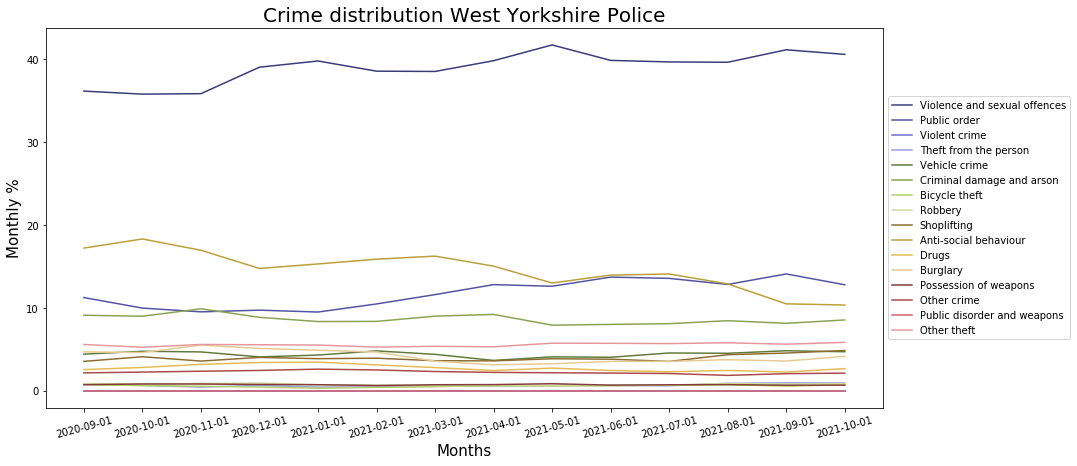

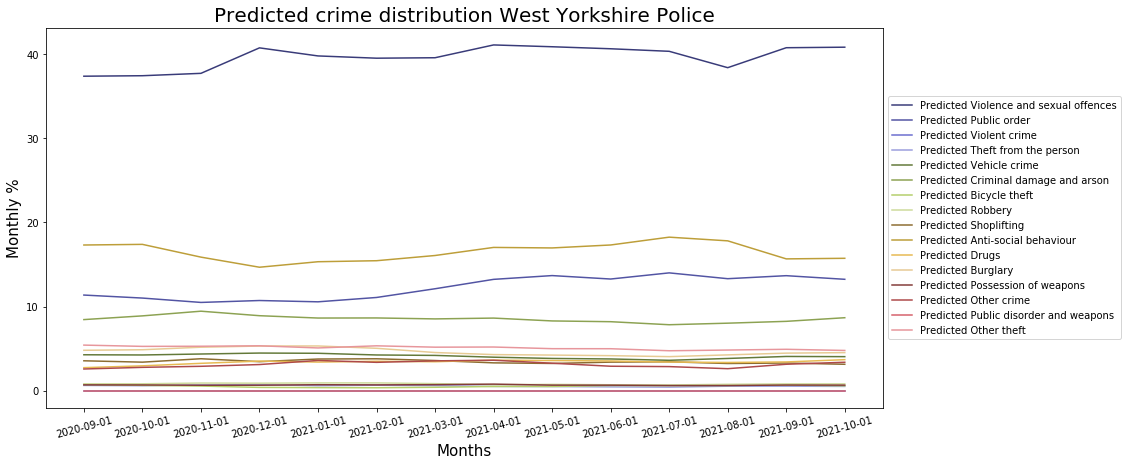

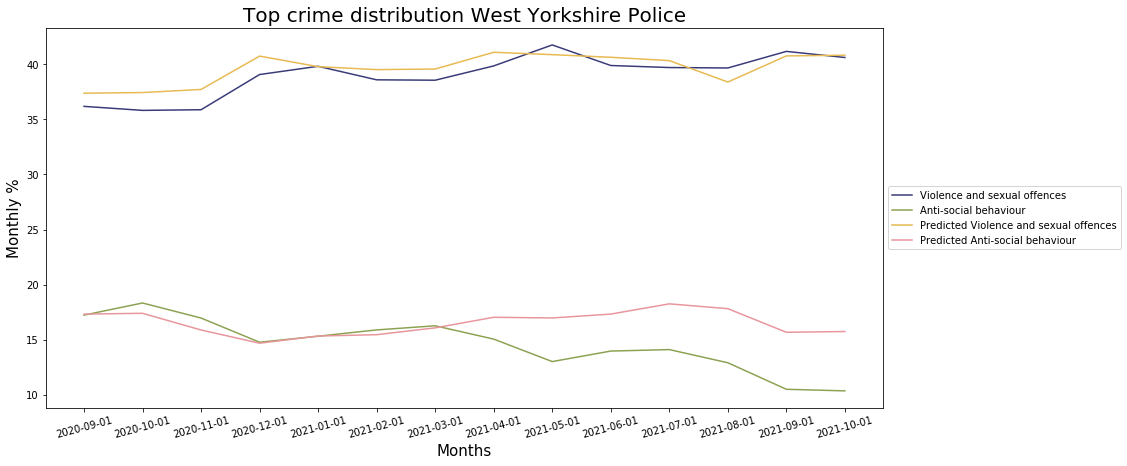

<Figure size 1080x504 with 0 Axes>

In [14]:
area = 'West Yorkshire Police' ## Change if u wish for another area
tempdf = df_dist[df_dist.area == area].copy()
predicted_crime_list = ['Predicted ' + crime for crime in crime_list]
smallcrime = ['Violence and sexual offences', 'Anti-social behaviour', 
              'Predicted Violence and sexual offences',
              'Predicted Anti-social behaviour']
colors = plt.cm.tab20b(np.linspace(0, 1, 20))

plt.rcParams['figure.figsize'] = [15,7]

x = tempdf.month
i = 0
for crime in crime_list:
    y = tempdf[crime]
    plt.plot(x, y, label=f'{crime}', color=colors[i])
    i += 1

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'Crime distribution {area}', size = 20)
plt.xlabel('Months', size = 15)
plt.ylabel('Monthly %', size = 15)
plt.xticks(rotation = 15)
plt.savefig(f'Real distribution {area}.png')
plt.show()
plt.clf()

i = 0
for crime in predicted_crime_list:
    y = tempdf[crime]
    plt.plot(x, y, label=f'{crime}', color=colors[i])
    i += 1

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'Predicted crime distribution {area}', size = 20)
plt.xlabel('Months', size = 15)
plt.ylabel('Monthly %', size = 15)
plt.xticks(rotation = 15)
plt.savefig(f'Predicted distribution {area}.png')
plt.show()
plt.clf()

i = 0
for crime in smallcrime:
    y = tempdf[crime]
    plt.plot(x, y, label=f'{crime}', color=colors[i])
    i += 5

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'Top crime distribution {area}', size = 20)
plt.xlabel('Months', size = 15)
plt.ylabel('Monthly %', size = 15)
plt.xticks(rotation = 15)
plt.savefig(f'Comparison top {area}.png')
plt.show()
plt.clf()

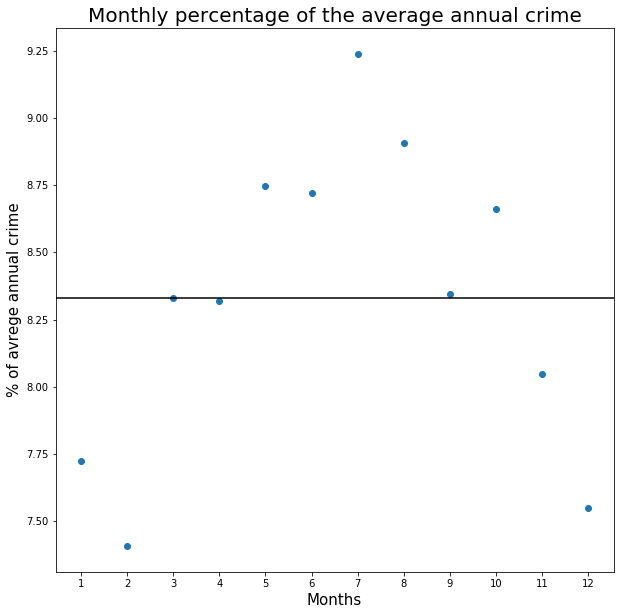

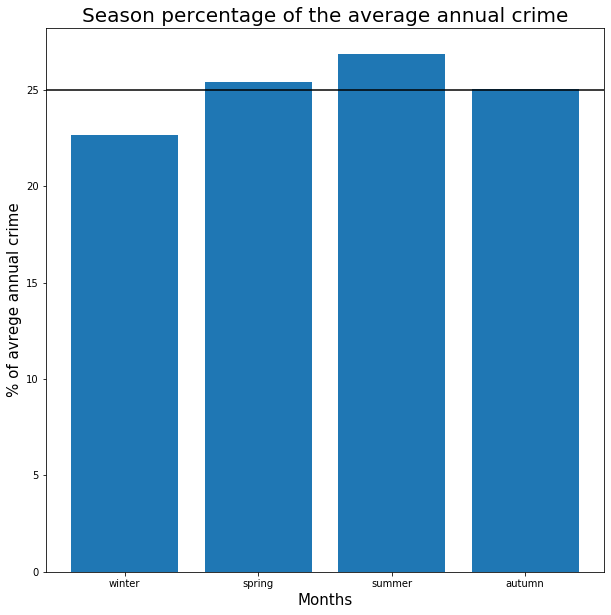

<Figure size 720x720 with 0 Axes>

In [15]:
tempdf = smalldf.groupby('month').sum()[['crime']].reset_index()
tempdf['year'] = (tempdf.month.map(lambda x: x.split('-')[0])).astype(int)
tempdf['mon'] = (tempdf.month.map(lambda x: x.split('-')[1])).astype(int)
tempdf = pd.concat([tempdf.groupby(['year', 'mon']).month.count().reset_index().mon.value_counts().reset_index().rename(
        {'mon': 'nrmon','index': 'mon'}, axis=1).sort_values('mon').reset_index().drop('index', axis=1),
        tempdf.groupby('mon').crime.sum().reset_index().rename(
        {'Month': 'total','mon': 'mon2'}, axis=1)],axis=1).drop('mon2', axis =1)
tempdf['avg'] = tempdf.crime / tempdf.nrmon
tempdf['per'] = tempdf.avg * 100 / sum(tempdf.avg)

seasons = {'Season': ['winter', 'spring', 'summer', 'autumn'],
            'crime': [tempdf.per[0] + tempdf.per[1] + tempdf.per[11],
                    sum(tempdf.per[2:5]),
                    sum(tempdf.per[5:8]),
                    sum(tempdf.per[8:11])]}


plt.rcParams['figure.figsize'] = [10,10]

x = tempdf.mon
y = tempdf.per

plt.scatter(x, y)
plt.xticks(ticks=x)
plt.axhline(y=8.33, color = 'black')
plt.xlabel('Months', size = 15)
plt.ylabel('% of avrege annual crime', size = 15)
plt.title('Monthly percentage of the average annual crime', size = 20)
plt.savefig('Scatter monthly.png')
plt.show()
plt.clf()

x = pd.DataFrame.from_dict(seasons).Season
y = pd.DataFrame.from_dict(seasons).crime

plt.bar(x, y)
plt.xticks(ticks=x)
plt.axhline(y=25, color = 'black')
plt.xlabel('Months', size = 15)
plt.ylabel('% of avrege annual crime', size = 15)
plt.title('Season percentage of the average annual crime', size = 20)
plt.savefig('Bar seasonal.png')
plt.show()
plt.clf()

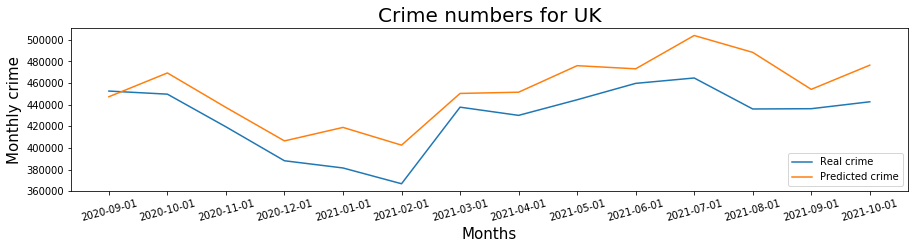

<Figure size 1080x216 with 0 Axes>

In [16]:
plt.rcParams['figure.figsize'] = [15,3]

tempdf = uk_df_crime[uk_df_crime.area == 'Small UK']

x = tempdf.month
y_real = tempdf.crime
y_pred = tempdf.predicted

plt.plot(x, y_real, label = 'Real crime')
plt.plot(x, y_pred, label = 'Predicted crime')

plt.title('Crime numbers for UK', size = 20)
plt.legend(loc="lower right")
plt.xlabel('Months', size = 15)
plt.ylabel('Monthly crime', size = 15)
plt.xticks(rotation = 15)
plt.savefig('Crime UK.png')
plt.show()
plt.clf()

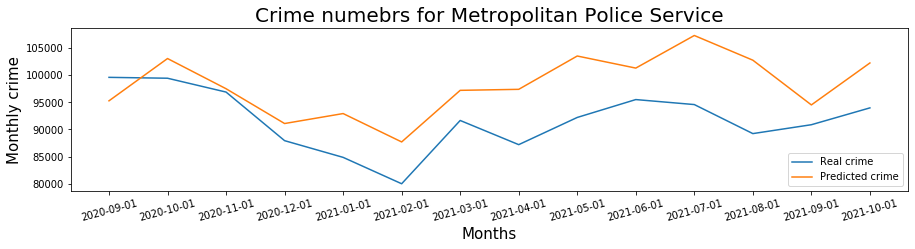

<Figure size 1080x216 with 0 Axes>

In [17]:
plt.rcParams['figure.figsize'] = [15,3]

area = 'Metropolitan Police Service' ## Change if u wish for another area
tempdf = df_crime[df_crime.area == area]

x = tempdf.month
y_real = tempdf.crime
y_pred = tempdf.predicted

plt.plot(x, y_real, label = 'Real crime')
plt.plot(x, y_pred, label = 'Predicted crime')

plt.title(f'Crime numebrs for {area}', size = 20)
plt.legend(loc="lower right")
plt.xlabel('Months', size = 15)
plt.ylabel('Monthly crime', size = 15)
plt.xticks(rotation = 15)
plt.savefig(f'Crime {area}.png')
plt.show()
plt.clf()

### Result interpretation

In [18]:
df_type_average = df_results_dist.groupby('Crime').mean()

In [19]:
df_area_results = df_results_dist.groupby('Area').mean()
df_area_results['MAE/average'] = df_results_crime.set_index('Area').sort_index()['MAE/average']
df_area_results['RMSE/average'] = df_results_crime.set_index('Area').sort_index()['RMSE/average']

In [20]:
df_average_results = uk_df_results_crime[['Area', 'MAE/average', 'RMSE/average']]
dictionary = {'Area': 'Average area models',
              'MAE/average': df_area_results['MAE/average'].mean(), 
              'RMSE/average': df_area_results['RMSE/average'].mean(),
              'MAE type': df_results_dist.groupby('Area').mean().mean().MAE, 
              'RMSE type': df_results_dist.groupby('Area').mean().mean().RMSE}
df_average_results = df_average_results.append(dictionary, ignore_index=True)
df_average_results.set_index('Area', inplace= True)

In [21]:
df_type_average

,MAE,RMSE
Crime,,
Anti-social behaviour,6.212079,7.301421
Bicycle theft,0.343921,0.411553
Burglary,0.560105,0.663263
Criminal damage and arson,0.838737,1.001316
Drugs,0.703789,0.874368
Other crime,0.641026,0.769184
Other theft,0.817895,0.974500
Possession of weapons,0.175395,0.205789
Public disorder and weapons,0.000000,0.000000


In [22]:
df_average_results

,MAE/average,RMSE/average,MAE type,RMSE type
Area,,,,
Full UK,6.585813,0.774730,NaN,NaN
Small UK,5.943353,0.662347,NaN,NaN
Average area models,8.187158,0.987121,1.100133,1.297982


In [23]:
df_area_results

,MAE,RMSE,MAE/average,RMSE/average
Area,,,,
Avon and Somerset Constabulary,0.574625,0.709375,11.559782,1.335155
Bedfordshire Police,0.536375,0.652312,3.402418,0.421096
Cambridgeshire Constabulary,0.702437,0.824187,6.885989,0.940649
City of London Police,3.794375,4.323750,27.681437,3.341697
Cleveland Police,0.854937,0.985750,4.310491,0.519810
Cumbria Constabulary,1.033062,1.310313,4.483368,0.509988
Derbyshire Constabulary,1.538313,1.779437,10.176072,1.200559
Devon & Cornwall Police,0.600625,0.736437,5.172659,0.624159
Dorset Police,0.946500,1.166000,6.461583,0.832858
